# Azure Cognitive Services : Text Analytics API

In this notebook, we will use the [Azure Cognitive Services Text Analytics API - Sentiment Analysis](https://docs.microsoft.com/en-us/azure/cognitive-services/text-analytics/overview) to predict the sentiment of the tweets.

We will compare this pre-trained cloud model to the baseline model from [main.ipynb](main.ipynb).

## Load project modules and data

We will use basic python packages, and the [`azure`](https://pypi.org/project/azure/) package to access the Azure Cognitive Services Text Analytics API. The secrets are stored in the `.env` file.

In [1]:
# Import custom helper libraries
import os
import sys

# Maths modules
import pandas as pd


src_path = os.path.abspath(os.path.join("../src"))
if src_path not in sys.path:
    sys.path.append(src_path)

import features.helpers as feat_helpers
import data.helpers as data_helpers
import visualization.helpers as viz_helpers


# Load environment variables from .env file
from dotenv import load_dotenv

load_dotenv()
AZURE_TEXT_ANALYTICS_KEY=os.getenv("AZURE_TEXT_ANALYTICS_KEY")
AZURE_TEXT_ANALYTICS_ENDPOINT=os.getenv("AZURE_TEXT_ANALYTICS_ENDPOINT")

# Sample data for development
TEXT_SAMPLE_SIZE = 2000  # <= 0 for all


In [2]:

# Download and unzip CSV files
!cd .. && make dataset && cd notebooks


>>> Downloading and extracting data files...
Data files already downloaded.
>>> OK.



In [3]:
# Load data from CSV
df = pd.read_csv(
    os.path.join(
        "..", "data", "raw", "training.1600000.processed.noemoticon.csv"
    ),
    names=["target", "id", "date", "flag", "user", "text"],
)

# Reduce memory usage
df = data_helpers.reduce_dataframe_memory_usage(df)

# Drop useless columns
df.drop(columns=["id", "date", "flag", "user"], inplace=True)

# Replace target values with labels
df.target.replace(
    {
        0: "NEGATIVE",
        2: "NEUTRAL",
        4: "POSITIVE",
    },
    inplace=True,
)

# Sample data
if TEXT_SAMPLE_SIZE > 0:
    df = data_helpers.balance_sample(df, "target", TEXT_SAMPLE_SIZE)

df.describe()


,target,text
count,2000,2000
unique,2,2000
top,NEGATIVE,@xnausikaax oh no! where did u order from? tha...
freq,1000,1


## Classification Model

Now we can measure the performance of our model defined in [custom_azure_text_analysis_classifier.py](../src/models/custom_azure_text_analysis_classifier.py). We are going to use the same metrics as our baseline model defined in [main.ipynb](main.ipynb).

### Basic model from Azure Cognitive Service for Language

In this model, we will use Azure's API results to predict the sentiment of the tweets. The API returns 3 possible sentiment values: _positive_, _negative_, and _neutral_. The _neutral_ value considered as half positive and half negative.

2022-01-06 13:02:39.953336: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-06 13:02:39.953360: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
2022-01-06 13:02:45.330991: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-06 13:02:45.331014: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-06 13:02:45.331030: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not 

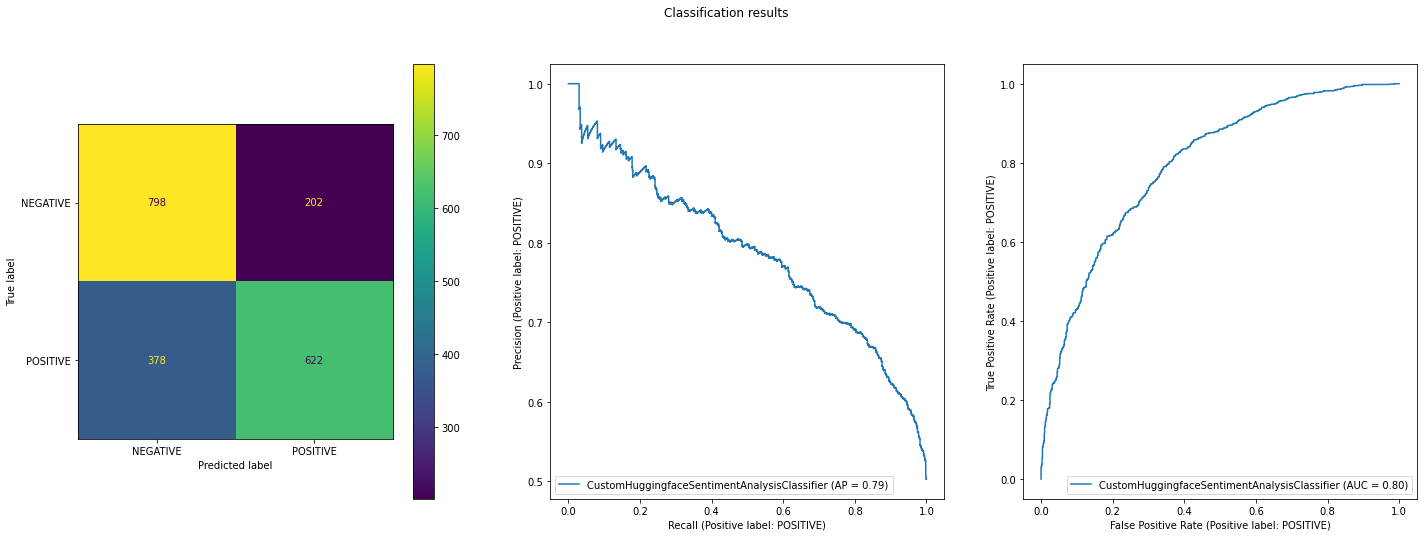

In [4]:
from models.custom_huggingface_sentiment_analysis_classifier import (
    CustomHuggingfaceSentimentAnalysisClassifier,
)


cls = CustomHuggingfaceSentimentAnalysisClassifier()

cache_json_path = os.path.join("..", "results", "huggingface_cache.json")
if os.path.exists(cache_json_path):
    cls.load_cache_json(filename=cache_json_path)
else:
    cls.fit(X=df.text.values, y=df.target.values)
    cls.save_cache_json(filename=cache_json_path)


viz_helpers.plot_classifier_results(
    cls,
    df.text.values,
    df.target.values,
    title="Classification results",
)


The performances on the dataset are slightly better than our baseline model : 
- Average Precision = 0.75 (baseline = 0.73 , +2.7%)
- ROC AUC = 0.78 (baseline = 0.74 , +5.4%)



This model is also biased towards the positive class, but less than our baseline model : it predicted 26% (baseline = 35% , -26%) more _POSITIVE_ (1115) messages than _NEGATIVE_ (885).
